In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gmaps
import os
import scipy.stats as stats
from scipy.stats import linregress
import requests
from config import g_key

In [2]:
# Reading in cleaned data
culture_data = pd.read_csv("Cleaned_Date_Culture_Data.csv")
dna_data = pd.read_csv("Cleaned_Date_DNA_Data.csv")

# Determining the Beach with the highest E. coli levels

In [3]:
# Getting mean E. coli level per beach of the culture measurement
beach_culture_avg = culture_data.groupby("Beach").mean()["Culture Reading Mean"]
beach_culture_avg

Beach
12th Street     151.680685
57th Street     154.944431
63rd Street     306.450355
Calumet         227.592369
Fargo            44.843750
Foster          136.394808
Howard           64.095519
Humboldt         26.770000
Juneway          64.274840
Lane            141.744086
Leone            80.315529
Loyola           96.827419
Montrose        296.325608
Montrose Dog    307.287472
North Avenue     88.373684
North Shore      93.681387
Oak Street       70.586783
Oakwood          98.525500
Ohio Street     111.216121
Osterman        126.842822
Rainbow         254.184405
Rogers           63.451542
South Shore     204.522317
Name: Culture Reading Mean, dtype: float64

In [4]:
beach_culture_avg.to_csv("Culture Beach Data.csv")

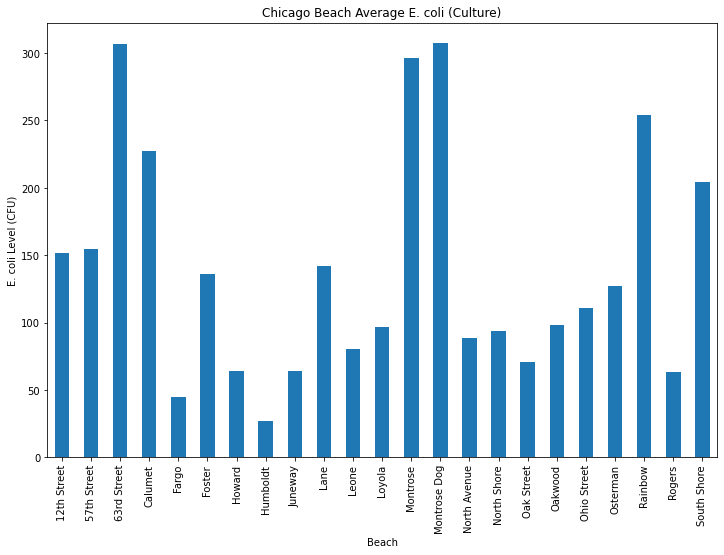

<Figure size 432x288 with 0 Axes>

In [5]:
beach_culture_avg.plot(kind='bar', figsize=(12,8))
plt.ylabel('E. coli Level (CFU)')
plt.title('Chicago Beach Average E. coli (Culture)')
plt.show()
plt.savefig("output/Beach_Culture_Levels")

In [6]:
beach_dna_avg = dna_data.groupby("Beach").mean()["DNA Reading Mean"]
beach_dna_avg

Beach
12th Street                        677.739410
57th Street                        341.875410
63rd Street                        823.011876
Calumet                            516.911944
Foster                             200.337954
Hartigan (Albion)                  458.830693
Howard                             404.903041
Humboldt                          2065.181053
Leone                              308.458804
Margaret T Burroughs (31st)        693.496783
Marion Mahony Griffin (Jarvis)     295.021667
Montrose                           596.424171
North Avenue                       213.359946
Oak Street                         187.700339
Oakwood                            249.603158
Ohio Street                        359.520109
Osterman                           333.573510
Rainbow                            649.664941
Rogers                            1220.797872
South Shore                        539.419159
Name: DNA Reading Mean, dtype: float64

In [7]:
beach_dna_avg.to_csv("DNA Beach Data.csv")

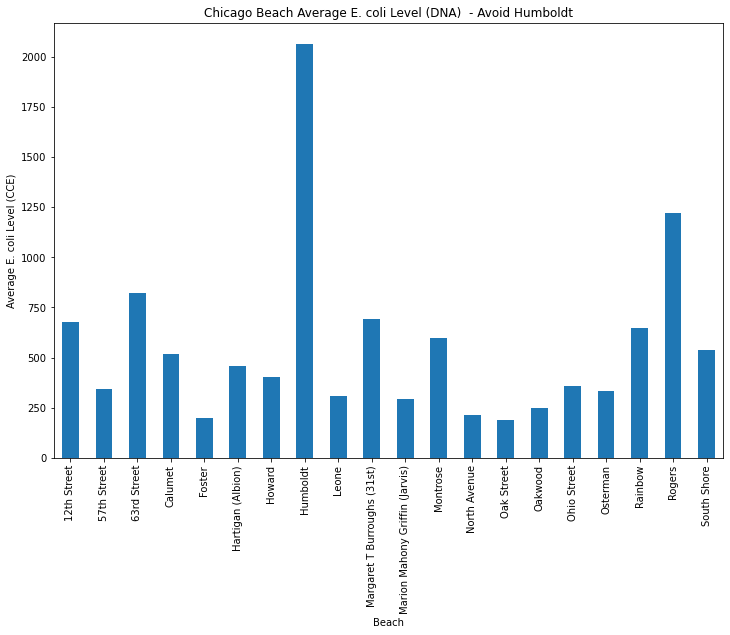

<Figure size 432x288 with 0 Axes>

In [8]:
beach_dna_avg.plot(kind='bar', figsize=(12,8))
plt.ylabel('Average E. coli Level (CCE)')
plt.title('Chicago Beach Average E. coli Level (DNA)  - Avoid Humboldt')
plt.show()
plt.savefig("output/Beach_DNA_Levels")

Heatmap to Visualize Beaches

In [9]:
culture_beach_lat_long_df = culture_data[["Beach", "Latitude", "Longitude"]]
culture_beach_lat_long_df = culture_beach_lat_long_df.drop_duplicates(subset="Beach")
culture_beach_data = pd.read_csv("Culture Beach Data.csv")
beach_culture_df = pd.merge(culture_beach_data, culture_beach_lat_long_df, on="Beach", how="inner")
beach_culture_df.head()

,Beach,Culture Reading Mean,Latitude,Longitude
0,12th Street,151.680685,41.8638,-87.6083
1,57th Street,154.944431,41.7911,-87.5797
2,63rd Street,306.450355,41.7827,-87.5748
3,Calumet,227.592369,41.7142,-87.5299
4,Fargo,44.843750,42.0161,-87.6647


In [10]:
dna_beach_lat_long_df = dna_data[["Beach", "Latitude", "Longitude"]]
dna_beach_lat_long_df = dna_beach_lat_long_df.drop_duplicates(subset="Beach")
dna_beach_data = pd.read_csv("DNA Beach Data.csv")
dna_beach_df = pd.merge(dna_beach_data, dna_beach_lat_long_df, on="Beach", how="inner")
dna_beach_df.head()

,Beach,DNA Reading Mean,Latitude,Longitude
0,12th Street,677.739410,41.8638,-87.6083
1,57th Street,341.875410,41.7911,-87.5797
2,63rd Street,823.011876,41.7827,-87.5748
3,Calumet,516.911944,41.7142,-87.5299
4,Foster,200.337954,41.9785,-87.6515


In [11]:
# Configuring gmaps key
gmaps.configure(api_key=g_key)

In [12]:
# Creating heatmap based on culture data
locations = beach_culture_df[["Latitude", "Longitude"]]
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=beach_culture_df["Culture Reading Mean"], 
                                 dissipating=False, max_intensity=beach_culture_df["Culture Reading Mean"].max(),
                                 point_radius = 0.01)
fig.add_layer(heat_layer)
new_marker = gmaps.marker_layer(locations, info_box_content=beach_culture_df["Beach"])
fig.add_layer(new_marker)
fig

Figure(layout=FigureLayout(height='420px'))

In [13]:
# Creating heatmap based on DNA data
locations = dna_beach_df[["Latitude", "Longitude"]]
fig2 = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=dna_beach_df["DNA Reading Mean"], 
                                 dissipating=False, max_intensity=dna_beach_df["DNA Reading Mean"].max(),
                                 point_radius = 0.01)
fig2.add_layer(heat_layer)
new_marker = gmaps.marker_layer(locations, info_box_content=dna_beach_df["Beach"])
fig2.add_layer(new_marker)
fig2

Figure(layout=FigureLayout(height='420px'))

# Determining the Most Closures

In [14]:
#establish thresholds for the readings to "closure levels"
#https://data.cityofchicago.org/Parks-Recreation/Beach-Lab-Data/2ivx-z93u/

#Culture Threshold (CFU Colony Forming Units/ 100 ml of water)
culture_thresh = 235

#DNA Threshold (CCE calibrator Cell equivalents / 100 ml of water)
dna_thresh = 1000

In [15]:
#filter existing Dataframes to remove all acceptable days
#Assume that the Mean was used for threshold analysis
#Culture
closure_cult_df = culture_data[culture_data["Culture Reading Mean"] >= culture_thresh]

#DNA
closure_dna_df = dna_data[dna_data["DNA Reading Mean"] >= dna_thresh]

In [16]:
#test
closure_cult_df.head()

,Unnamed: 0,Culture Test ID,Culture Sample 1 Timestamp,Beach,Culture Sample 1 Reading,Culture Sample 2 Reading,Culture Reading Mean,Latitude,Longitude,Sample Date,Sample Time
1,2374,112689.0,2016-06-01 07:15:00,Calumet,629.0,1300.0,904.3,41.7142,-87.5299,2016-06-01,07:15:00
2,2375,112669.0,2016-06-01 08:00:00,Calumet,345.0,517.0,422.3,41.7142,-87.5299,2016-06-01,08:00:00
4,4983,93134.0,2015-07-07 00:00:00,Leone,727.0,727.0,727.0,42.0131,-87.6635,2015-07-07,00:00:00
13,4993,105382.0,2014-07-15 00:00:00,63rd Street,1414.0,1300.0,1355.8,41.7827,-87.5748,2014-07-15,00:00:00
18,4999,95242.0,2015-06-02 00:00:00,South Shore,291.0,328.0,308.9,41.7689,-87.5636,2015-06-02,00:00:00


In [17]:
#test
closure_dna_df.head()

,Unnamed: 0,DNA Test ID,DNA Sample Timestamp,Beach,DNA Sample 1 Reading,DNA Sample 2 Reading,DNA Reading Mean,Latitude,Longitude,Sample Date,Sample Time
39,53,13778.0,2020-07-08 00:00:00,Oak Street,2560.0,3001.0,2771.7,41.9032,-87.6235,2020-07-08,00:00:00
40,54,13785.0,2020-07-06 12:52:00,North Avenue,1651.0,1928.0,1784.1,41.9148,-87.6273,2020-07-06,12:52:00
50,64,13800.0,2020-07-06 12:51:00,South Shore,930.0,2143.0,1411.7,41.7689,-87.5636,2020-07-06,12:51:00
58,72,13797.0,2020-07-08 00:00:00,North Avenue,1651.0,1928.0,1784.1,41.9148,-87.6273,2020-07-08,00:00:00
59,73,13774.0,2020-07-08 00:00:00,South Shore,930.0,2143.0,1411.7,41.7689,-87.5636,2020-07-08,00:00:00


In [18]:
closure_dna_df["Sample Month"]= ""
closure_cult_df["Sample Month"]=""

<ipython-input-18-d1f6d6964ea2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closure_dna_df["Sample Month"]= ""
<ipython-input-18-d1f6d6964ea2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closure_cult_df["Sample Month"]=""


In [19]:
closure_dna_df["Sample Month"]= pd.DatetimeIndex(closure_dna_df["Sample Date"]).month
closure_dna_df.head()

<ipython-input-19-dc6b9ff97e9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closure_dna_df["Sample Month"]= pd.DatetimeIndex(closure_dna_df["Sample Date"]).month


,Unnamed: 0,DNA Test ID,DNA Sample Timestamp,Beach,DNA Sample 1 Reading,DNA Sample 2 Reading,DNA Reading Mean,Latitude,Longitude,Sample Date,Sample Time,Sample Month
39,53,13778.0,2020-07-08 00:00:00,Oak Street,2560.0,3001.0,2771.7,41.9032,-87.6235,2020-07-08,00:00:00,7
40,54,13785.0,2020-07-06 12:52:00,North Avenue,1651.0,1928.0,1784.1,41.9148,-87.6273,2020-07-06,12:52:00,7
50,64,13800.0,2020-07-06 12:51:00,South Shore,930.0,2143.0,1411.7,41.7689,-87.5636,2020-07-06,12:51:00,7
58,72,13797.0,2020-07-08 00:00:00,North Avenue,1651.0,1928.0,1784.1,41.9148,-87.6273,2020-07-08,00:00:00,7
59,73,13774.0,2020-07-08 00:00:00,South Shore,930.0,2143.0,1411.7,41.7689,-87.5636,2020-07-08,00:00:00,7


In [20]:
closure_cult_df["Sample Month"]= pd.DatetimeIndex(closure_cult_df["Sample Date"]).month
closure_cult_df.head()

<ipython-input-20-a4c1dc6707e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closure_cult_df["Sample Month"]= pd.DatetimeIndex(closure_cult_df["Sample Date"]).month


,Unnamed: 0,Culture Test ID,Culture Sample 1 Timestamp,Beach,Culture Sample 1 Reading,Culture Sample 2 Reading,Culture Reading Mean,Latitude,Longitude,Sample Date,Sample Time,Sample Month
1,2374,112689.0,2016-06-01 07:15:00,Calumet,629.0,1300.0,904.3,41.7142,-87.5299,2016-06-01,07:15:00,6
2,2375,112669.0,2016-06-01 08:00:00,Calumet,345.0,517.0,422.3,41.7142,-87.5299,2016-06-01,08:00:00,6
4,4983,93134.0,2015-07-07 00:00:00,Leone,727.0,727.0,727.0,42.0131,-87.6635,2015-07-07,00:00:00,7
13,4993,105382.0,2014-07-15 00:00:00,63rd Street,1414.0,1300.0,1355.8,41.7827,-87.5748,2014-07-15,00:00:00,7
18,4999,95242.0,2015-06-02 00:00:00,South Shore,291.0,328.0,308.9,41.7689,-87.5636,2015-06-02,00:00:00,6


In [21]:
cl_cult_group=closure_cult_df.groupby("Sample Month")["Culture Test ID"].count()
print(cl_cult_group)
cl_cult_group_df=pd.DataFrame(cl_cult_group)
cl_cult_group_df

Sample Month
5    161
6    515
7    659
8    719
9     62
Name: Culture Test ID, dtype: int64


,Culture Test ID
Sample Month,
5,161
6,515
7,659
8,719
9,62


In [22]:
cl_dna_group=closure_dna_df.groupby("Sample Month")["DNA Test ID"].count()
print(cl_dna_group)
cl_dna_group_df=pd.DataFrame(cl_dna_group)
cl_dna_group_df

Sample Month
5     28
6    156
7    289
8    182
9     21
Name: DNA Test ID, dtype: int64


,DNA Test ID
Sample Month,
5,28
6,156
7,289
8,182
9,21


In [23]:
## Closure counts per month

#set up bins for the months of the year
#bins would be equivalent for both, reading timestamps the same

month_labels = [ "January",
              "February",
              "March",
              "April",
              "May",
              "June",
              "July",
              "August",
              "September",
              "October",
              "November",
              "December"]

summer_labels= ["May",
              "June",
              "July",
              "August",
              "September"]

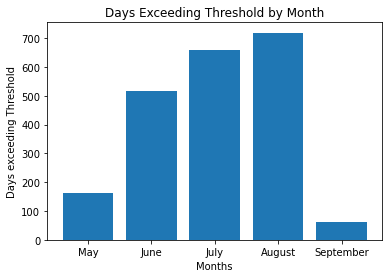

In [24]:
x_axis=np.arange(len(cl_cult_group_df))
tick_locations = [value for value in x_axis]

plt.bar(x_axis,cl_cult_group_df["Culture Test ID"])
plt.xticks(tick_locations,summer_labels)
plt.title("Days Exceeding Threshold by Month")
plt.xlabel("Months")
plt.ylabel("Days exceeding Threshold")
plt.savefig("output/Culture_Days_Exceeing_Threshold_by_Month")

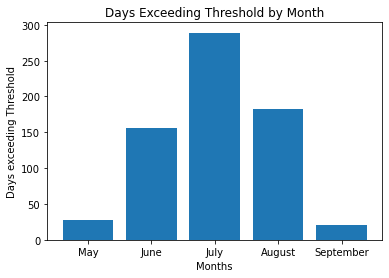

In [25]:
#DNA Graph
# (uses x_axis and tick from above)
    
plt.bar(x_axis,cl_dna_group_df["DNA Test ID"])
plt.xticks(tick_locations,summer_labels,)
plt.title("Days Exceeding Threshold by Month")
plt.xlabel("Months")
plt.ylabel("Days exceeding Threshold")
plt.savefig("output/DNA_Days_Exceeing_Threshold_by_Month")

In [26]:
#box and whisker
#seperate all into months
months = [5,6,7,8,9]
closure_cult_df

,Unnamed: 0,Culture Test ID,Culture Sample 1 Timestamp,Beach,Culture Sample 1 Reading,Culture Sample 2 Reading,Culture Reading Mean,Latitude,Longitude,Sample Date,Sample Time,Sample Month
1,2374,112689.0,2016-06-01 07:15:00,Calumet,629.0,1300.0,904.3,41.7142,-87.5299,2016-06-01,07:15:00,6
2,2375,112669.0,2016-06-01 08:00:00,Calumet,345.0,517.0,422.3,41.7142,-87.5299,2016-06-01,08:00:00,6
4,4983,93134.0,2015-07-07 00:00:00,Leone,727.0,727.0,727.0,42.0131,-87.6635,2015-07-07,00:00:00,7
13,4993,105382.0,2014-07-15 00:00:00,63rd Street,1414.0,1300.0,1355.8,41.7827,-87.5748,2014-07-15,00:00:00,7
18,4999,95242.0,2015-06-02 00:00:00,South Shore,291.0,328.0,308.9,41.7689,-87.5636,2015-06-02,00:00:00,6
...,...,...,...,...,...,...,...,...,...,...,...,...
14791,24238,110639.0,2012-07-31 00:00:00,57th Street,2420.0,1299.7,1773.5,41.7911,-87.5797,2012-07-31,00:00:00,7
14792,24240,112692.0,2016-06-01 08:20:00,63rd Street,2420.0,2420.0,2420.0,41.7827,-87.5748,2016-06-01,08:20:00,6
14797,24247,101871.0,2009-06-02 00:00:00,57th Street,307.6,387.6,345.3,41.7911,-87.5797,2009-06-02,00:00:00,6
14800,24251,113037.0,2016-06-23 07:25:00,63rd Street,488.0,198.0,310.8,41.7827,-87.5748,2016-06-23,07:25:00,6


In [27]:
closure_cult_df["Date"]=""
closure_cult_df["Date"]= pd.DatetimeIndex(closure_cult_df["Sample Date"]).day
closure_cult_df
filthyholiday = closure_cult_df[closure_cult_df["Sample Month"]==7]
filthyholiday
filthyholiday = filthyholiday[filthyholiday["Date"]==5]
filthyholiday

<ipython-input-27-a33f8e23522b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closure_cult_df["Date"]=""
<ipython-input-27-a33f8e23522b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closure_cult_df["Date"]= pd.DatetimeIndex(closure_cult_df["Sample Date"]).day


,Unnamed: 0,Culture Test ID,Culture Sample 1 Timestamp,Beach,Culture Sample 1 Reading,Culture Sample 2 Reading,Culture Reading Mean,Latitude,Longitude,Sample Date,Sample Time,Sample Month,Date
1261,6595,108583.0,2012-07-05 00:00:00,Calumet,160.7,387.3,249.5,41.71420,-87.529900,2012-07-05,00:00:00,7,5
1595,7037,103966.0,2007-07-05 00:00:00,Rainbow,2419.6,151.5,605.4,41.75800,-87.551000,2007-07-05,00:00:00,7,5
1872,7400,113194.0,2016-07-05 06:46:00,Montrose,150.0,1733.0,509.9,41.96550,-87.638500,2016-07-05,06:46:00,7,5
3940,10091,108585.0,2012-07-05 00:00:00,South Shore,2420.0,103.4,500.2,41.76890,-87.563600,2012-07-05,00:00:00,7,5
6530,13468,103968.0,2007-07-05 00:00:00,63rd Street,816.4,648.8,727.8,41.78270,-87.574800,2007-07-05,00:00:00,7,5
13056,21996,108586.0,2012-07-05 00:00:00,63rd Street,1553.1,2420.0,1938.7,41.78270,-87.574800,2012-07-05,00:00:00,7,5
13545,22653,108595.0,2012-07-05 00:00:00,Montrose Dog,770.1,648.8,706.9,41.96869,-87.642617,2012-07-05,00:00:00,7,5


In [28]:
## Box plots

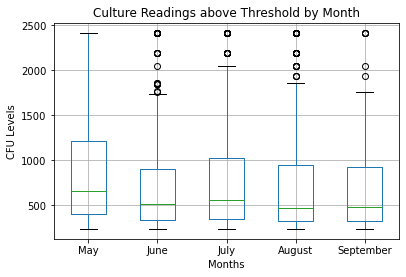

In [29]:
boxplot = closure_cult_df.boxplot(column=["Culture Reading Mean"], by=["Sample Month"])
plt.title("Culture Readings above Threshold by Month")
plt.suptitle("")
plt.show
plt.xlabel("Months")
plt.xticks([1,2,3,4,5], summer_labels)
plt.ylabel("CFU Levels")
plt.savefig("output/culture_boxplot_closing_above_thresh")

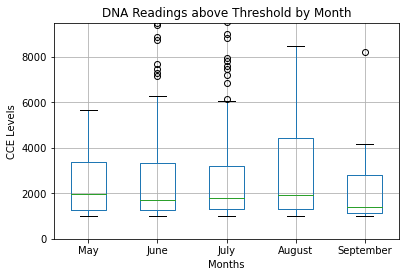

In [30]:
boxplot_dna = closure_dna_df.boxplot(column=["DNA Reading Mean"], by=["Sample Month"])
plt.title("DNA Readings above Threshold by Month")
plt.suptitle("")
plt.show
plt.xlabel("Months")
plt.xticks([1,2,3,4,5], summer_labels)
plt.ylabel("CCE Levels")
plt.ylim(0, 9500)
plt.savefig("output/DNA_boxplot_closing_above_thresh")

In [31]:
#Additional Stats - Find Average Level above threshold
cl_cult_mean=closure_cult_df.groupby("Sample Month")["Culture Reading Mean"].mean()
print(cl_cult_mean)
cl_cult_mean_df=pd.DataFrame(cl_cult_mean)
cl_cult_mean_df
cl_cult_mean_df["Mean CFU level above Threshold"] = cl_cult_mean_df["Culture Reading Mean"]-culture_thresh
cl_cult_mean_df

Sample Month
5    930.657764
6    780.439223
7    808.103187
8    745.955633
9    752.185484
Name: Culture Reading Mean, dtype: float64


,Culture Reading Mean,Mean CFU level above Threshold
Sample Month,,
5,930.657764,695.657764
6,780.439223,545.439223
7,808.103187,573.103187
8,745.955633,510.955633
9,752.185484,517.185484


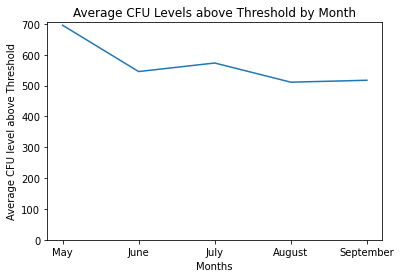

<Figure size 432x288 with 0 Axes>

In [32]:
#Line graph showing levels above threshold in each month
x_axis = [0,1,2,3,4]
points = cl_cult_mean_df["Mean CFU level above Threshold"]
plt.plot(x_axis, points)
plt.xticks(np.arange(5), summer_labels)
plt.yticks(np.arange(0,800,100))

plt.xlabel("Months")
plt.ylabel("Average CFU level above Threshold")
plt.title("Average CFU Levels above Threshold by Month")
plt.show()
plt.savefig("output/Average_CFU_Levels_above_Threshold_by_Month")

In [33]:
#Additional Stats - Find Average Level above threshold
cl_dna_mean=closure_dna_df.groupby("Sample Month")["DNA Reading Mean"].mean()
print(cl_dna_mean)
cl_dna_mean_df=pd.DataFrame(cl_dna_mean)
cl_dna_mean_df

Sample Month
5    2463.157143
6    4273.587821
7    3168.998616
8    4799.155495
9    2513.985714
Name: DNA Reading Mean, dtype: float64


,DNA Reading Mean
Sample Month,
5,2463.157143
6,4273.587821
7,3168.998616
8,4799.155495
9,2513.985714


In [34]:
cl_dna_mean_df["Mean CCE level above Threshold"] = cl_dna_mean_df["DNA Reading Mean"]-dna_thresh
cl_dna_mean_df

,DNA Reading Mean,Mean CCE level above Threshold
Sample Month,,
5,2463.157143,1463.157143
6,4273.587821,3273.587821
7,3168.998616,2168.998616
8,4799.155495,3799.155495
9,2513.985714,1513.985714


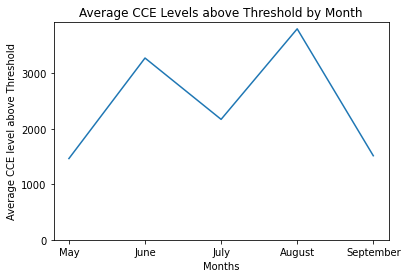

<Figure size 432x288 with 0 Axes>

In [35]:
#Line graph showing levels above threshold in each month
x_axis = [0,1,2,3,4]
points = cl_dna_mean_df["Mean CCE level above Threshold"]
plt.plot(x_axis, points)
plt.xticks(np.arange(5), summer_labels)
plt.yticks(np.arange(0,4000,1000))

plt.xlabel("Months")
plt.ylabel("Average CCE level above Threshold")
plt.title("Average CCE Levels above Threshold by Month")
plt.show()
plt.savefig("output/Average_CCE_Levels_above_Threshold_by_Month")

# What year had the highest E. coli levels?

Culture Data


Bar graph:
-The culture data had data for 11 years total from 2006-2016

-According to the culture data 2007 was the year with the highest blooms.

Box plot:

-On average over the years E. Coli levels are around the same every year but 2007 is still the highest year on average (confirms box-lot)


Dna Data:

Bar graph:
-The DNA data had data for 6 years from 2015 - 2020

-but the the 2020 year only had 3 points of data and cut it out. 

-According to the DNA data 2018 was the year with the highest blooms

Box plot:
-2018 on average had the highest E coli levels 

-2016 and 2019 on average had the lowest E. Coli levels

In [36]:
culture_data["Date"] = pd.to_datetime(culture_data["Sample Date"],format= "%Y-%m-%d")
culture_data["Date"] = pd.to_datetime(culture_data["Sample Date"], yearfirst=True)

In [37]:
culture_data["Year"] = pd.DatetimeIndex(culture_data["Date"]).year

In [38]:
culture_data.head()

,Unnamed: 0,Culture Test ID,Culture Sample 1 Timestamp,Beach,Culture Sample 1 Reading,Culture Sample 2 Reading,Culture Reading Mean,Latitude,Longitude,Sample Date,Sample Time,Date,Year
0,2231,113666.0,2016-08-04 08:30:00,Humboldt,1.0,1.0,1.0,41.90643,-87.703717,2016-08-04,08:30:00,2016-08-04,2016
1,2374,112689.0,2016-06-01 07:15:00,Calumet,629.0,1300.0,904.3,41.71420,-87.529900,2016-06-01,07:15:00,2016-06-01,2016
2,2375,112669.0,2016-06-01 08:00:00,Calumet,345.0,517.0,422.3,41.71420,-87.529900,2016-06-01,08:00:00,2016-06-01,2016
3,4980,109008.0,2013-05-26 00:00:00,57th Street,17.0,20.0,18.4,41.79110,-87.579700,2013-05-26,00:00:00,2013-05-26,2013
4,4983,93134.0,2015-07-07 00:00:00,Leone,727.0,727.0,727.0,42.01310,-87.663500,2015-07-07,00:00:00,2015-07-07,2015


In [39]:
groupedyear_c = culture_data.groupby(["Year"])

In [40]:
groupedyear_c.nunique()

,Unnamed: 0,Culture Test ID,Culture Sample 1 Timestamp,Beach,Culture Sample 1 Reading,Culture Sample 2 Reading,Culture Reading Mean,Latitude,Longitude,Sample Date,Sample Time,Date,Year
Year,,,,,,,,,,,,,
2006,1267,1267,74,20,389,392,795,18,18,74,1,74,1
2007,1320,1320,83,18,415,426,906,17,17,83,1,83,1
2008,1264,1264,81,18,381,383,734,17,17,81,1,81,1
2009,1423,1423,83,19,393,409,841,18,18,83,1,83,1
2010,1222,1222,76,17,378,386,752,17,17,76,1,76,1
2011,1327,1327,82,18,386,388,803,18,18,82,1,82,1
2012,1372,1372,94,18,384,388,813,18,18,94,1,94,1
2013,1394,1394,94,18,267,266,771,18,18,94,1,94,1
2014,1388,1388,93,18,228,234,743,18,18,93,1,93,1


In [41]:
groupedyear_c.sum()

,Unnamed: 0,Culture Test ID,Culture Sample 1 Reading,Culture Sample 2 Reading,Culture Reading Mean,Latitude,Longitude
Year,,,,,,,
2006,18545147,129603543.0,247133.7,246886.9,234436.9,53104.36990,-111018.405800
2007,18919359,132591967.0,301043.7,287293.8,276674.6,55318.48100,-115659.469500
2008,18676608,127563587.0,162481.0,159041.0,154449.3,52975.02070,-110753.964500
2009,20722519,133898115.0,241047.8,237677.0,226527.3,59628.95160,-124682.879700
2010,18087649,108693778.0,177138.3,188501.4,168811.8,51195.21880,-107066.952800
2011,19246711,126390940.0,209532.7,207459.9,188676.6,55599.24653,-116268.444739
2012,20097679,148563850.0,211358.1,207318.4,196159.9,57474.47659,-120206.566107
2013,20788617,149543300.0,238076.5,226182.4,219713.2,58400.04127,-122136.296241
2014,20231599,144056820.0,235748.8,232422.6,218625.3,58153.35006,-121612.246958


In [42]:
culture_yaxis = groupedyear_c["Culture Reading Mean"].mean()
culture_yaxis

Year
2006    185.033070
2007    209.601970
2008    122.190902
2009    159.189951
2010    138.143863
2011    142.182818
2012    142.973688
2013    157.613486
2014    157.511023
2015    139.970403
2016    125.999566
Name: Culture Reading Mean, dtype: float64

In [43]:
culture_xaxis = ["2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016"]

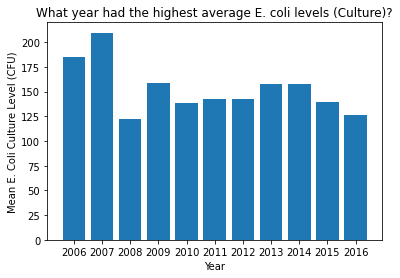

<Figure size 432x288 with 0 Axes>

In [107]:
plt.bar(culture_xaxis, culture_yaxis)

plt.title("What year had the highest average E. coli levels (Culture)?")
plt.xlabel("Year")
plt.ylabel("Mean E. Coli Culture Level (CFU)")

plt.show()
plt.savefig("output/Culture_Year_barchart.png")

In [45]:
culture_labels = ["2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016"]

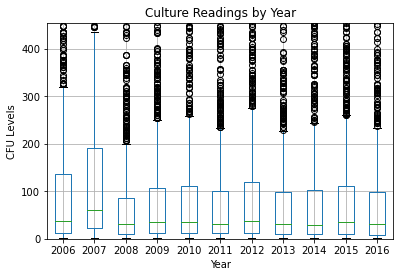

In [46]:
culutrebox = culture_data.boxplot(column= ["Culture Reading Mean"], by =["Year"])
plt.title("Culture Readings by Year")
plt.suptitle("")
plt.show
plt.xlabel("Year")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11], culture_labels )
plt.ylabel("CFU Levels")
plt.ylim(0,455)
plt.savefig("output/Culture_Year_boxplot.png")

In [47]:
dna_data = pd.read_csv("Cleaned_Date_DNA_Data.csv")
dna_data

,Unnamed: 0,DNA Test ID,DNA Sample Timestamp,Beach,DNA Sample 1 Reading,DNA Sample 2 Reading,DNA Reading Mean,Latitude,Longitude,Sample Date,Sample Time
0,3,10601.0,2019-06-03 12:08:00,63rd Street,15.0,121.0,42.6,41.78270,-87.574800,2019-06-03,12:08:00
1,4,10600.0,2019-06-03 12:08:00,South Shore,1006.0,16.0,126.9,41.76890,-87.563600,2019-06-03,12:08:00
2,5,10582.0,2019-06-03 12:10:00,North Avenue,69.0,8.0,23.5,41.91480,-87.627300,2019-06-03,12:10:00
3,6,10646.0,2019-06-03 12:12:00,Howard,90.0,169.0,123.3,42.01880,-87.666300,2019-06-03,12:12:00
4,7,10599.0,2019-06-03 12:08:00,Rainbow,150.0,245.0,191.7,41.75800,-87.551000,2019-06-03,12:08:00
...,...,...,...,...,...,...,...,...,...,...,...
6856,24273,3116.0,2017-06-21 00:00:00,Humboldt,1083.0,1028.0,1055.1,41.90643,-87.703717,2017-06-21,00:00:00
6857,24274,7874.0,2018-07-11 00:00:00,Howard,198.0,642.0,356.5,42.01880,-87.666300,2018-07-11,00:00:00
6858,24277,2047.0,2016-08-24 13:13:00,North Avenue,47.0,13.0,24.7,41.91480,-87.627300,2016-08-24,13:13:00
6859,24279,2980.0,2017-06-18 00:00:00,57th Street,10.0,84.0,29.0,41.79110,-87.579700,2017-06-18,00:00:00


In [48]:
dna_data["Date"] = pd.to_datetime(dna_data["Sample Date"],format= "%Y-%m-%d")
dna_data["Date"] = pd.to_datetime(dna_data["Sample Date"], yearfirst=True)

In [49]:
dna_data["Year"] = pd.DatetimeIndex(dna_data["Date"]).year

In [50]:
dna_data.head()

,Unnamed: 0,DNA Test ID,DNA Sample Timestamp,Beach,DNA Sample 1 Reading,DNA Sample 2 Reading,DNA Reading Mean,Latitude,Longitude,Sample Date,Sample Time,Date,Year
0,3,10601.0,2019-06-03 12:08:00,63rd Street,15.0,121.0,42.6,41.7827,-87.5748,2019-06-03,12:08:00,2019-06-03,2019
1,4,10600.0,2019-06-03 12:08:00,South Shore,1006.0,16.0,126.9,41.7689,-87.5636,2019-06-03,12:08:00,2019-06-03,2019
2,5,10582.0,2019-06-03 12:10:00,North Avenue,69.0,8.0,23.5,41.9148,-87.6273,2019-06-03,12:10:00,2019-06-03,2019
3,6,10646.0,2019-06-03 12:12:00,Howard,90.0,169.0,123.3,42.0188,-87.6663,2019-06-03,12:12:00,2019-06-03,2019
4,7,10599.0,2019-06-03 12:08:00,Rainbow,150.0,245.0,191.7,41.7580,-87.5510,2019-06-03,12:08:00,2019-06-03,2019


In [51]:
dna_data = dna_data[dna_data["Year"]!= 2020]

In [52]:
groupedyear_d = dna_data.groupby(["Year"])

In [53]:
groupedyear_d.nunique()

,Unnamed: 0,DNA Test ID,DNA Sample Timestamp,Beach,DNA Sample 1 Reading,DNA Sample 2 Reading,DNA Reading Mean,Latitude,Longitude,Sample Date,Sample Time,Date,Year
Year,,,,,,,,,,,,,
2015,271,270,54,5,259,263,204,5,5,54,1,54,1
2016,626,625,269,9,305,297,541,9,9,70,126,70,1
2017,1995,1995,119,20,831,826,1640,20,20,102,21,102,1
2018,1959,1959,166,20,931,902,1695,20,20,102,60,102,1
2019,1963,1963,925,20,642,636,1388,20,20,102,145,102,1


In [54]:
groupedyear_d.sum()

,Unnamed: 0,DNA Test ID,DNA Sample 1 Reading,DNA Sample 2 Reading,DNA Reading Mean,Latitude,Longitude
Year,,,,,,,
2015,4040421,36654.0,117240.0,164146.9,105401.0,11327.18020,-23731.872200
2016,8256264,831065.0,162055.0,187252.0,146708.9,26187.35990,-54831.572000
2017,28965557,8140867.0,1423826.0,1415619.0,1201150.9,83587.29546,-174806.603834
2018,28511666,15742931.0,2381393.0,1884195.0,1731629.5,82078.22020,-171651.969400
2019,4548950,23768312.0,710925.0,675143.0,569081.9,82243.37129,-172000.164911


In [55]:
dna_yaxis = groupedyear_d["DNA Reading Mean"].mean()
dna_yaxis

Year
2015    388.933579
2016    234.359265
2017    602.080652
2018    883.935426
2019    289.904177
Name: DNA Reading Mean, dtype: float64

In [56]:
dna_xaxis = ["2015", "2016", "2017", "2018", "2019"]

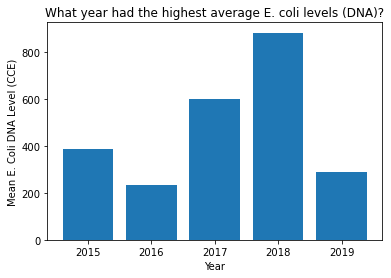

<Figure size 432x288 with 0 Axes>

In [108]:
plt.bar(dna_xaxis, dna_yaxis)

plt.title("What year had the highest average E. coli levels (DNA)?")
plt.xlabel("Year")
plt.ylabel("Mean E. Coli DNA Level (CCE)")

plt.show()
plt.savefig("output/DNA_Year_barchart.png")

In [58]:
dna_labels = ["2015", "2016", "2017", "2018", "2019"]

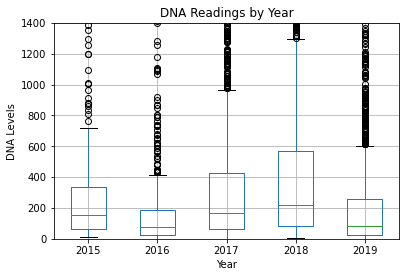

In [59]:
dnabox = dna_data.boxplot(column= ["DNA Reading Mean"], by =["Year"])
plt.title("DNA Readings by Year")
plt.suptitle("")
plt.show
plt.xlabel("Year")
plt.xticks([1,2,3,4,5], dna_labels )
plt.ylabel("DNA Levels")
plt.ylim(0,1400)
plt.savefig("output/DNA_Year_boxplot.png")

# Which month as the highest E. coli levels?

In recent years, the data from the DNA results indicates that July has become the month with the highest E. coli levels. However, the culture data indicates that previously, May, July and August were among the months with the highest levels. Part of this could be due to the fact that the culture data is a larger dataset, and has more values. 

In [60]:
culture_data.head()

,Unnamed: 0,Culture Test ID,Culture Sample 1 Timestamp,Beach,Culture Sample 1 Reading,Culture Sample 2 Reading,Culture Reading Mean,Latitude,Longitude,Sample Date,Sample Time,Date,Year
0,2231,113666.0,2016-08-04 08:30:00,Humboldt,1.0,1.0,1.0,41.90643,-87.703717,2016-08-04,08:30:00,2016-08-04,2016
1,2374,112689.0,2016-06-01 07:15:00,Calumet,629.0,1300.0,904.3,41.71420,-87.529900,2016-06-01,07:15:00,2016-06-01,2016
2,2375,112669.0,2016-06-01 08:00:00,Calumet,345.0,517.0,422.3,41.71420,-87.529900,2016-06-01,08:00:00,2016-06-01,2016
3,4980,109008.0,2013-05-26 00:00:00,57th Street,17.0,20.0,18.4,41.79110,-87.579700,2013-05-26,00:00:00,2013-05-26,2013
4,4983,93134.0,2015-07-07 00:00:00,Leone,727.0,727.0,727.0,42.01310,-87.663500,2015-07-07,00:00:00,2015-07-07,2015


In [61]:
test = "2016-08-04"

formatted = datetime.datetime.strptime(test, "%Y-%m-%d")
formatted.month

8

In [62]:
dna_data["Sample Month"] = ""

for index, row in dna_data.iterrows():
    
    date = row["Sample Date"]
    
    formatted = datetime.datetime.strptime(date, "%Y-%m-%d")
    
    dna_data.loc[index, "Sample Month"] = formatted.month
    
# using striptime: https://stackoverflow.com/questions/26105804/extract-month-from-date-in-python/26105888


<ipython-input-62-bc5ff0002362>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dna_data["Sample Month"] = ""
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [63]:
culture_data["Sample Month"] = ""

for index, row in culture_data.iterrows():
    
    date = row["Sample Date"]
    
    formatted = datetime.datetime.strptime(date, "%Y-%m-%d")
    
    culture_data.loc[index, "Sample Month"] = formatted.month

In [64]:
culture_data.head()

,Unnamed: 0,Culture Test ID,Culture Sample 1 Timestamp,Beach,Culture Sample 1 Reading,Culture Sample 2 Reading,Culture Reading Mean,Latitude,Longitude,Sample Date,Sample Time,Date,Year,Sample Month
0,2231,113666.0,2016-08-04 08:30:00,Humboldt,1.0,1.0,1.0,41.90643,-87.703717,2016-08-04,08:30:00,2016-08-04,2016,8
1,2374,112689.0,2016-06-01 07:15:00,Calumet,629.0,1300.0,904.3,41.71420,-87.529900,2016-06-01,07:15:00,2016-06-01,2016,6
2,2375,112669.0,2016-06-01 08:00:00,Calumet,345.0,517.0,422.3,41.71420,-87.529900,2016-06-01,08:00:00,2016-06-01,2016,6
3,4980,109008.0,2013-05-26 00:00:00,57th Street,17.0,20.0,18.4,41.79110,-87.579700,2013-05-26,00:00:00,2013-05-26,2013,5
4,4983,93134.0,2015-07-07 00:00:00,Leone,727.0,727.0,727.0,42.01310,-87.663500,2015-07-07,00:00:00,2015-07-07,2015,7


In [65]:
dna_by_month = dna_data.groupby("Sample Month")
culture_by_month = culture_data.groupby("Sample Month")

In [66]:
dna_y_axis = dna_by_month["DNA Reading Mean"].mean()
dna_y_axis

Sample Month
5    294.675561
6    491.519486
7    612.911664
8    606.399228
9    441.428708
Name: DNA Reading Mean, dtype: float64

In [67]:
x_axis = ["May", "June", "July", "August", "September"]

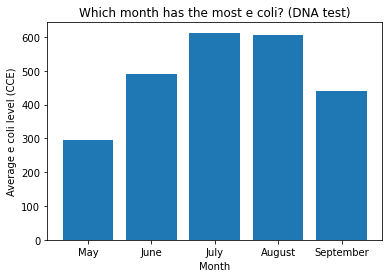

In [68]:
plt.bar(x_axis, dna_y_axis)

plt.title("Which month has the most e coli? (DNA test)")
plt.xlabel("Month")
plt.ylabel("Average e coli level (CCE)")

plt.savefig("output/DNA_monthly_mean.png")

plt.show()

In [69]:
culture_y_axis = culture_by_month["Culture Reading Mean"].mean()
culture_y_axis

Sample Month
5     162.750043
6     131.254973
7     163.658208
8     160.541246
9     147.932780
10      1.000000
Name: Culture Reading Mean, dtype: float64

In [70]:
#dropping october because there's so little data
culture_y_axis=culture_y_axis.drop(labels=10)

In [71]:
x_axis = ["May", "June", "July", "August", "September"]

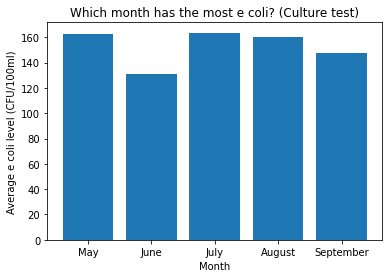

In [72]:
plt.bar(x_axis, culture_y_axis)


plt.title("Which month has the most e coli? (Culture test)")
plt.xlabel("Month")
plt.ylabel("Average e coli level (CFU/100ml)")

plt.savefig("output/Culture_monthly_mean.png")

plt.show()

In [73]:
dna_by_date = dna_data.groupby("Sample Date")
culture_by_date = culture_data.groupby("Sample Date")


In [74]:
daily_dna_means = dna_by_date["DNA Reading Mean"].mean()
daily_culture_means = culture_by_date["Culture Reading Mean"].mean()

In [75]:
dates = dna_data["Sample Date"].unique()

In [76]:
dates.sort()
dates

array(['2015-05-26', '2015-05-27', '2015-05-28', '2015-06-01',
       '2015-06-02', '2015-06-03', '2015-06-04', '2015-06-09',
       '2015-06-10', '2015-06-11', '2015-06-12', '2015-06-16',
       '2015-06-17', '2015-06-18', '2015-06-19', '2015-06-23',
       '2015-06-24', '2015-06-25', '2015-06-26', '2015-06-30',
       '2015-07-01', '2015-07-02', '2015-07-07', '2015-07-08',
       '2015-07-09', '2015-07-10', '2015-07-14', '2015-07-15',
       '2015-07-16', '2015-07-17', '2015-07-21', '2015-07-22',
       '2015-07-23', '2015-07-24', '2015-07-28', '2015-07-29',
       '2015-07-30', '2015-07-31', '2015-08-04', '2015-08-05',
       '2015-08-06', '2015-08-07', '2015-08-11', '2015-08-12',
       '2015-08-13', '2015-08-14', '2015-08-18', '2015-08-19',
       '2015-08-20', '2015-08-21', '2015-08-25', '2015-08-26',
       '2015-08-27', '2015-08-28', '2016-05-26', '2016-06-01',
       '2016-06-02', '2016-06-03', '2016-06-04', '2016-06-05',
       '2016-06-08', '2016-06-09', '2016-06-10', '2016-

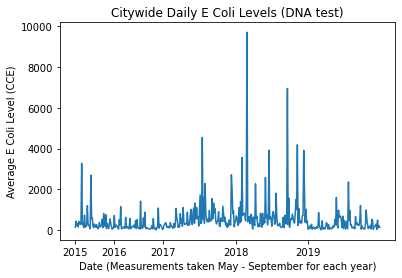

In [77]:
dna_daily_x = dates
dna_daily_y = daily_dna_means

plt.plot(dna_daily_x, dna_daily_y)


plt.title("Citywide Daily E Coli Levels (DNA test)")
plt.xlabel("Date (Measurements taken May - September for each year)")
plt.xticks(('2015-05-26', '2016-05-26', '2017-05-26', '2018-05-25', '2019-05-24'), ("2015", "2016", "2017", "2018", "2019"))
plt.ylabel("Average E Coli Level (CCE)")

plt.savefig("output/Culture_monthly_mean.png")

plt.show()

In [78]:
culture_dates = culture_data["Sample Date"].unique()

In [79]:
culture_dates.sort()
culture_dates

array(['2006-05-23', '2006-05-24', '2006-05-25', '2006-05-26',
       '2006-05-30', '2006-05-31', '2006-06-01', '2006-06-02',
       '2006-06-05', '2006-06-06', '2006-06-07', '2006-06-08',
       '2006-06-12', '2006-06-13', '2006-06-14', '2006-06-15',
       '2006-06-16', '2006-06-19', '2006-06-20', '2006-06-21',
       '2006-06-22', '2006-06-23', '2006-06-25', '2006-06-26',
       '2006-06-27', '2006-06-28', '2006-06-29', '2006-06-30',
       '2006-07-03', '2006-07-07', '2006-07-10', '2006-07-11',
       '2006-07-12', '2006-07-13', '2006-07-14', '2006-07-17',
       '2006-07-18', '2006-07-19', '2006-07-20', '2006-07-21',
       '2006-07-22', '2006-07-24', '2006-07-25', '2006-07-26',
       '2006-07-27', '2006-07-28', '2006-07-29', '2006-07-31',
       '2006-08-01', '2006-08-02', '2006-08-03', '2006-08-04',
       '2006-08-07', '2006-08-08', '2006-08-09', '2006-08-10',
       '2006-08-11', '2006-08-12', '2006-08-13', '2006-08-14',
       '2006-08-15', '2006-08-16', '2006-08-17', '2006-

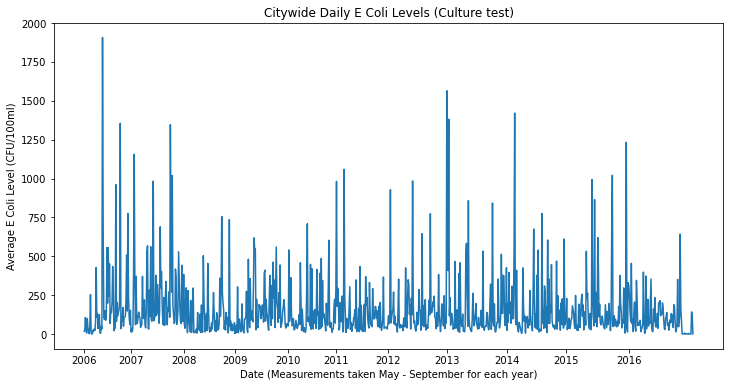

In [80]:
plt.figure(figsize=(12,6))

plt.plot(culture_dates, daily_culture_means)

plt.title("Citywide Daily E Coli Levels (Culture test)")
plt.xlabel("Date (Measurements taken May - September for each year)")
plt.xticks(('2006-05-23', '2007-05-28', '2008-05-27', '2009-05-11', '2010-05-25', '2011-05-23', 
            '2012-05-22', '2013-05-21', '2014-05-20', '2015-05-19', '2016-05-26'), 
           ("2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016"))
plt.ylabel("Average E Coli Level (CFU/100ml)")


plt.savefig("output/Culture_monthly_mean.png")

plt.show()

In [81]:
#tidying the daily means and exporting as .csv

In [82]:
daily_dna_means = daily_dna_means.to_frame()
daily_culture_means = daily_culture_means.to_frame()

In [83]:
daily_dna_means.reset_index(drop=False, inplace=True)
daily_culture_means.reset_index(drop=False, inplace=True)

In [84]:
daily_dna_means=daily_dna_means.rename(columns = {"Sample Date":"Date","DNA Reading Mean":"Citywide Mean E Coli Level"})
daily_culture_means.columns

Index(['Sample Date', 'Culture Reading Mean'], dtype='object')

In [85]:
daily_culture_means = daily_culture_means.rename(columns = {"Sample Date":"Date","Culture Reading Mean":"Citywide Mean E Coli Level"})

In [86]:
daily_dna_means.to_csv('DNA_daily_citywide_means.csv')
daily_culture_means.to_csv('culture_daily_citywide_means.csv')

In [87]:
########## looking at correlation with milwaukee #################

In [88]:
#importing Milwaukee weather data

In [89]:
Milwaukee = pd.read_csv("Milwaukee_DNA_Rainfall.csv")
Milwaukee.head()

,Unnamed: 0,Date,Rainfall (In)
0,390,2015-05-26,0.0
1,274,2015-05-27,0.0
2,406,2015-05-28,0.0
3,200,2015-06-01,0.0
4,178,2015-06-02,0.0


In [90]:
#adding the rolling average. The window parameter below sets how many days to average

Milwaukee["Rolling avg"] = Milwaukee.rolling(window=14, on="Date")["Rainfall (In)"].mean()

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html

In [91]:
Milwaukee.head(20)

,Unnamed: 0,Date,Rainfall (In),Rolling avg
0,390,2015-05-26,0.0,NaN
1,274,2015-05-27,0.0,NaN
2,406,2015-05-28,0.0,NaN
3,200,2015-06-01,0.0,NaN
4,178,2015-06-02,0.0,NaN
5,430,2015-06-03,0.0,NaN
6,392,2015-06-04,0.0,NaN
7,409,2015-06-09,0.0,NaN
8,420,2015-06-10,0.0,NaN
9,283,2015-06-11,0.0,NaN


In [92]:
#add to the e coli data

comparison = daily_dna_means.merge(Milwaukee, how="left", on="Date")
comparison.head(20)

,Date,Citywide Mean E Coli Level,Unnamed: 0,Rainfall (In),Rolling avg
0,2015-05-26,147.8,390,0.0,NaN
1,2015-05-27,438.0,274,0.0,NaN
2,2015-05-28,223.4,406,0.0,NaN
3,2015-06-01,331.0,200,0.0,NaN
4,2015-06-02,157.8,178,0.0,NaN
5,2015-06-03,420.8,430,0.0,NaN
6,2015-06-04,359.6,392,0.0,NaN
7,2015-06-09,278.2,409,0.0,NaN
8,2015-06-10,318.0,420,0.0,NaN
9,2015-06-11,3273.0,283,0.0,NaN


In [93]:
for index, row in comparison.iterrows():

    date = row["Date"]
    
    formatted = datetime.datetime.strptime(date, "%Y-%m-%d")
    
    comparison.loc[index, "year"] = formatted.year

In [94]:
#restricted this to 2017 onward, since we had the most complete e coli and weather data for those years

comparison = comparison.loc[comparison["year"]>=2017,:]
comparison.head()

,Date,Citywide Mean E Coli Level,Unnamed: 0,Rainfall (In),Rolling avg,year
124,2017-05-26,76.500000,290,0.0,0.0,2017.0
125,2017-05-27,222.893750,311,0.0,0.0,2017.0
126,2017-05-28,279.129412,186,0.0,0.0,2017.0
127,2017-05-29,365.970000,277,0.0,0.0,2017.0
128,2017-05-30,334.300000,380,0.0,0.0,2017.0


In [95]:
#plotting
mke_x = comparison["Citywide Mean E Coli Level"]
mke_y = comparison["Rolling avg"]

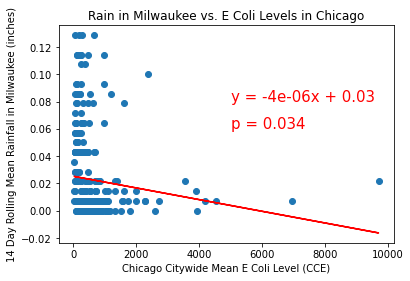

In [96]:
plt.scatter(mke_x, mke_y)
plt.ylabel("14 Day Rolling Mean Rainfall in Milwaukee (inches)")
plt.xlabel("Chicago Citywide Mean E Coli Level (CCE)")
plt.title("Rain in Milwaukee vs. E Coli Levels in Chicago")

(slope, intercept, rvalue, pvalue, stderr) = linregress(mke_x, mke_y)
regress_values = mke_x * slope + intercept
line_eq = "y = " + str(round(slope,6)) + "x + " + str(round(intercept,2))
plt.plot(mke_x,regress_values,"r-")
plt.annotate(line_eq,(5000,.08),fontsize=15,color="red")
plt.annotate(f"p = {round(pvalue,3)}",(5000,.06),fontsize=15,color="red")

plt.savefig("output/14_Day_Rolling_Rain_v_E_Coli")

# Is there a relationship between Milwaukee rainfall and Chicago beach E. coli levels?

When Milwaukee gets an unusually high amount of rain, the city's combined rainwater and sewage system dumps
excess water into Lake Michigan. There are documented cases of this leading to increased levels of e coli and 
other harmful substances in the area around Milwaukee: https://madison.com/ct/news/local/environment/as-rains-intensify-sewage-surges-into-wisconsin-waters/article_cc767155-3bb4-5d4e-9d68-fcaefc70bc4f.html
Including an outbreak of cryptosporidium in 1993 that made over 400,000 people in the Milwaukee area sick!

Our group wanted to know if Milwaukee's sewage overflows reached Chicago and increased e coli levels here. We used
the data from 2017 onward because we had the most complete weather and e coli data for those years, and a 14-day
rolling average to capture the overall raininess preceeding each measurement, and to give any sewage time to make it down to Chicago. We found that Chicago's e coli levels are actually negatively correlated with rain in Milwaukee. If there is an effect, it seems to be drowned out by other factors affecting our e coli levels, potentially including Chicago's own sewage management. 

1. Is there a relationship between Milwaukee rainfall and elevated E. coli level in the Chicago beaches?

Given the data analyzed, there does not appear to be a correlation between the rainfall and E. coli levels. Both the culture measurements and the DNA measurments yield poor r-squared values, 0.0045 and 0.00028 respectively, indicating there is not much of a relationship present. Additionally, both tests have p-values greater than 0.05, with 0.059 and 0.72 for the culture test and DNA test, respectively, indicating there is not a statistical significance in the data.

In [97]:
# Reading in Milwaukee rain data for culture sampling
culture_rain_data = pd.read_csv("Milwaukee_Culture_Rainfall.csv", index_col=0)

# Converting date to datetime format
culture_rain_data["Date"] = pd.to_datetime(culture_rain_data["Date"],format= "%Y-%m-%d")
culture_rain_data["Date"] = pd.to_datetime(culture_rain_data["Date"], yearfirst=True)
culture_rain_data["Year"] = pd.DatetimeIndex(culture_rain_data["Date"]).year
culture_rain_data["Month"] = pd.DatetimeIndex(culture_rain_data["Date"]).month

In [98]:
# Reading in city wide culture data
city_culture_ecoli = pd.read_csv("culture_daily_citywide_means.csv", index_col =0)
city_culture_ecoli["Date"] = pd.to_datetime(city_culture_ecoli["Date"],format= "%Y-%m-%d")

# Merging culture results with weather data
culture_rain_ecoli = pd.merge(culture_rain_data, city_culture_ecoli, how="left", on="Date")

The r-squared value is 0.004574507459009841
The p-value is 0.05983630141224942


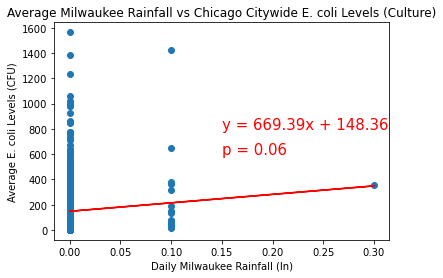

<Figure size 432x288 with 0 Axes>

In [99]:
# Plotting the weather data vs the culture technique E. coli levels 
# Calculate regression curve 
x_values = culture_rain_ecoli["Rainfall (In)"]
y_values = culture_rain_ecoli["Citywide Mean E Coli Level"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0.15,800),fontsize=15,color="red")
plt.annotate(f"p = {round(pvalue,3)}",(0.15, 600),fontsize=15,color="red")
plt.xlabel("Daily Milwaukee Rainfall (In)")
plt.ylabel("Average E. coli Levels (CFU)")
plt.title("Average Milwaukee Rainfall vs Chicago Citywide E. coli Levels (Culture)")
print(f"The r-squared value is {rvalue**2}")
print(f"The p-value is {pvalue}")
plt.show()
plt.savefig("output/Mil_Rain_vs_City_Culture_Data.png")

In [100]:
# Reading in the Milwaukee weather dates for DNA sampling
DNA_rain_data = pd.read_csv("Milwaukee_DNA_Rainfall.csv", index_col=0)
DNA_rain_data["Date"] = pd.to_datetime(DNA_rain_data["Date"],format= "%Y-%m-%d")
DNA_rain_data["Date"] = pd.to_datetime(DNA_rain_data["Date"], yearfirst=True)
DNA_rain_data["Year"] = pd.DatetimeIndex(DNA_rain_data["Date"]).year
DNA_rain_data["Month"] = pd.DatetimeIndex(DNA_rain_data["Date"]).month

In [101]:
# Reading in the city wide DNA data 
city_dna_ecoli = pd.read_csv("DNA_daily_citywide_means.csv", index_col =0)
city_dna_ecoli["Date"] = pd.to_datetime(city_dna_ecoli["Date"],format= "%Y-%m-%d")

# Merging DNA data with weather data
DNA_rain_ecoli = pd.merge(DNA_rain_data, city_dna_ecoli, how="left", on="Date")
DNA_rain_ecoli = DNA_rain_ecoli.dropna()

In [102]:
# Plotting the weather data vs the DNA technique E. coli levels 
# Calculate regression curve 
x_values = DNA_rain_ecoli["Rainfall (In)"]
y_values = DNA_rain_ecoli["Citywide Mean E Coli Level"]

The r-squared value is 4.939432649065349e-06
The p-value is 0.9633482666973501


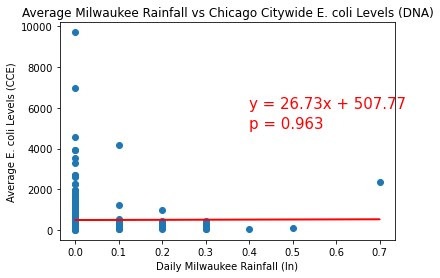

<Figure size 432x288 with 0 Axes>

In [103]:
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0.4,6000),fontsize=15,color="red")
plt.annotate(f"p = {round(pvalue,3)}",(0.4,5000),fontsize=15,color="red")
plt.xlabel("Daily Milwaukee Rainfall (In)")
plt.ylabel("Average E. coli Levels (CCE)")
plt.title("Average Milwaukee Rainfall vs Chicago Citywide E. coli Levels (DNA)")
print(f"The r-squared value is {rvalue**2}")
print(f"The p-value is {pvalue}")
plt.show()
plt.savefig("output/Mil_Rain_vs_City_DNA_Data.png")